# Homework 3: Interactive visualisation

In [74]:
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# package to define colormaps
import branca.colormap as cm

## Question 1: Unemployment rate in Europe

We import the topology of European countries. We delete Israel from the country list because according to https://en.wikipedia.org/wiki/List_of_European_countries_by_population, it is not in Europe.

We use the data of http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=une_rt_a&lang=en about the percentage of unemployment in the active population of each country. We clean the data so all country names are well matched between the database and the topology.

We think the percentage in the active population is more representative of what unemployment is, because if we take the total population we also give information about how many people are not active in the country, which is not what we are interested in.

In [141]:
## Topology
    # Import the topo
europe_topo_path = 'topojson\europe.topojson.json'
europe_topo_data = json.load(open(europe_topo_path))

    # Clean the topo
europe_countries = europe_topo_data['objects']['europe']['geometries']
europe_countries.remove([country for country in europe_countries if country['properties']['NAME']=='Israel'][0])

# Create the Europe map
#europe_map = folium.Map([56.8,23], tiles='cartodbpositron', zoom_start=3)
#folium.TopoJson(europe_topo_data,'objects.europe').add_to(europe_map)

## Data
    # Import the data
europe_db_path = r'topojson\Europe_unemployment.csv'
europe_db = pd.read_csv(europe_db_path).drop(['AGE','SEX','Flag and Footnotes','UNIT'],axis=1)

    # Clean the data
europe_db['Value'] = europe_db['Value'].apply(lambda x: np.nan if x==':' else x)
europe_db['Value'] = pd.to_numeric(europe_db['Value'])

europe_db['TIME'] = pd.to_numeric(europe_db['TIME'])

rename_dict = {'Germany (until 1990 former territory of the FRG)':'Germany'}
europe_db['GEO'] = europe_db['GEO'].apply(lambda x: rename_dict[x] if x in rename_dict.keys() else x)
europe_db.head()

,TIME,GEO,Value
0,2000,Belgium,6.9
1,2000,Bulgaria,16.4
2,2000,Czech Republic,8.8
3,2000,Denmark,4.3
4,2000,Germany,7.9


In [67]:
## Function creating the coloured Choropleth map of unemployment
def unemployment_map(year) :
    """Displays the map of unemployment in Europe for the given year"""
    
        # Create map
    europe_map = folium.Map([56.8,23], tiles='cartodbpositron', zoom_start=3)
    
        # Select Data
    db = europe_db[europe_db['TIME']==year].set_index('GEO')['Value'].dropna()
    
        # Define a colormap depending on the quantiles
    quantiles = [db.min(),db.quantile(0.25),db.quantile(0.5),db.quantile(0.75),db.max()]
    colors = ['#75FA00','#FAF300','#FAA600','#D51410','#D51410']
    colormap = cm.StepColormap(colors,quantiles,vmin=db.min(),vmax=db.max())
    colormap.caption = 'Unemployment color scale'
    
        # Colour function
    def europe_colors(country):
        """Returns the colour depending on the unemployment rate, white if undefined"""
        try:
            return colormap(db[country])
        except:
            return '#FFFFFF'
    
        # Add the colours to the map
    folium.TopoJson(europe_topo_data, 'objects.europe',
            style_function= lambda feature : {
            'fillColor' : europe_colors(feature['properties']['NAME']),
            'fillOpacity' : 1,
            'color' : 'black',
            'weight' : 1} 
            ).add_to(europe_map)
    colormap.add_to(europe_map)
    return europe_map

In [68]:
unemployment_map(2011)

## Question 2: Unemployment rate in Switzerland

In [105]:
## Topology
    # Import the topo
ch_topo_path = 'topojson\ch-cantons.topojson.json'
ch_topo_data = json.load(open(ch_topo_path))
    # Clean topo
    
rename_dict = {'Zürich':'Zurich', 'Bern/Berne':'Berne', 'Luzern':'Lucerne',
               'Obwalden':'Obwald', 'Nidwalden':'Nidwald', 'Glarus':'Glaris',
               'Zug':'Zoug', 'Solothurn':'Soleure', 'Basel-Stadt':'Bâle-Ville',
               'Basel-Landschaft':'Bâle-Campagne', 'Schaffhausen':'Schaffhouse',
               'Appenzell Ausserrhoden':'Appenzell Rhodes-Extérieures',
               'Appenzell Innerrhoden':'Appenzell Rhodes-Intérieures',
               'St. Gallen':'St-Gall', 'Graubünden/Grigioni':'Grisons', 
               'Aargau':'Argovie', 'Thurgau':'Thurgovie', 'Ticino':'Tessin',
               'Valais/Wallis':'Valais'}
ch_cantons = ch_topo_data['objects']['cantons']['geometries']
def change_name(x) :
    if x['properties']['name'] in rename_dict.keys() :
        x['properties']['name'] = rename_dict[x['properties']['name']]
ch_cantons = list(map(change_name, ch_cantons))

                  
# Create the ch map
#ch_map = folium.Map([46.85,8.15], tiles='cartodbpositron', zoom_start=7)
#folium.TopoJson(ch_topo_data,'objects.cantons').add_to(ch_map)

                  
## Data
    # Import the data
swiss_db_path = r'topojson\Swiss_unemployment.csv'
swiss_db = pd.read_csv(swiss_db_path, encoding = 'utf8').drop(["Mois","Total"],axis=1).drop(0)


#Separate in 3 databases: 0 with unemployement rate, 1 with number of unemployed people, 2 with number of people asking for a job
swiss_db_0 = swiss_db[[c for c in swiss_db.columns if '.' not in c]].set_index("Canton")
swiss_db_1 = swiss_db[["Canton"] + [c for c in swiss_db.columns if '.1' in c]].set_index("Canton")
swiss_db_2 = swiss_db[["Canton"] + [c for c in swiss_db.columns if '.2' in c]].set_index("Canton")

#Transform data to numeric values
swiss_db_0 = swiss_db_0.applymap(lambda x: float(x.replace("'","")))
swiss_db_1 = swiss_db_1.applymap(lambda x: int(x.replace("'","")))
swiss_db_2 = swiss_db_2.applymap(lambda x: int(x.replace("'","")))

#Rename columns
swiss_db_0.columns = list(map(lambda x: x.replace("Décembre ",""),swiss_db_0.columns))
swiss_db_1.columns = list(map(lambda x: x.replace("Décembre ","").replace(".1",""),swiss_db_1.columns))
swiss_db_2.columns = list(map(lambda x: x.replace("Décembre ","").replace(".2",""),swiss_db_2.columns))


swiss_asking = swiss_db_0/swiss_db_1*swiss_db_2

In [135]:
## Function creating the coloured Choropleth map of unemployment
def unemployment_ch_map(year,ch_db,extra_color=False) :
    """Displays the map of unemployment in Switzerland for the given year\n
       extra_color (default=0) is used to change the colour of the colourmap """
    
        # Create map
    ch_map = folium.Map([46.9,8.15], tiles='cartodbpositron', zoom_start=8)
    
        # Select Data
    db = ch_db[str(year)].dropna()
    
        # Define a colormap depending on the quantiles
    quantiles = [db.min(),db.quantile(0.25),db.quantile(0.5),db.quantile(0.75),db.max()]

    colors = ['#75FA00','#FAF300','#FAA600','#D51410','#D51410']
    if extra_color:
        colors =['#96F1DF','#6ABAC9','#3E82B2','#114A9B','#114A9B']
    colormap = cm.StepColormap(colors,quantiles,vmin=db.min(),vmax=db.max())
    colormap.caption = 'Unemployment color scale'
    
        # Colour function
    def ch_colors(canton):
        """Returns the colour depending on the unemployment rate, white if undefined"""
        try:
            return colormap(db[canton])
        except:
            return '#FFFFFF'
    
        # Add the colours to the map
    folium.TopoJson(ch_topo_data, 'objects.cantons',
            style_function= lambda feature : {
            'fillColor' : ch_colors(feature['properties']['name']),
            'fillOpacity' : 1,
            'color' : 'black',
            'weight' : 1} 
            ).add_to(ch_map)
    colormap.add_to(ch_map)
    return ch_map

In [136]:
unemployment_ch_map(2016,swiss_asking)

In [137]:
unemployment_ch_map(2016,swiss_db_0)

## Question 3

#### Unemployment by nationality

In [125]:
swiss_nat_db_path = r'topojson\Swiss_unemployment_nationality.csv'
swiss_nat_db = pd.read_csv(swiss_nat_db_path, encoding = 'utf8')

swiss_nat_db = swiss_nat_db.drop(['Mois','Total']+[c for c in swiss_nat_db.columns if '.' in c],axis=1)
swiss_nat_db.columns = list(map(lambda x: x.replace("Décembre ",""),swiss_nat_db.columns))

swiss_native = swiss_nat_db[swiss_nat_db['Nationalité'] == "Suisses"].set_index('Canton').drop('Nationalité',axis=1)
swiss_euro = swiss_nat_db[swiss_nat_db['Nationalité'] == "Etrangers"].set_index('Canton').drop('Nationalité',axis=1)

swiss_native = swiss_native.apply(pd.to_numeric)
swiss_euro = swiss_euro.applymap(lambda x: float(x) if '...' != x else np.nan)

swiss_diff = swiss_native - swiss_euro
swiss_diff

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Canton,,,,,,,,,,,,,,,,,
Zurich,-2.4,-2.8,-3.7,-4.3,-3.9,-3.8,-3.0,-2.8,-3.0,-4.3,-2.9,-2.7,-3.3,-3.4,-3.1,-3.5,-3.5
Berne,-2.7,-3.0,-4.8,-5.3,-4.6,-4.8,-4.1,-3.6,-4.0,-5.5,-4.2,-3.6,-4.2,-4.5,-4.1,-5.0,-5.2
Lucerne,-2.8,-3.2,-5.0,-5.2,-5.0,-4.7,-4.2,-3.8,-4.3,-5.8,-3.7,-3.7,-3.8,-3.7,-3.5,-3.9,-3.6
Uri,-2.3,-2.4,-2.9,-2.9,-3.3,-2.7,-4.0,-3.0,-4.0,-5.4,NaN,NaN,NaN,NaN,-5.2,-5.0,-4.7
Schwyz,-1.2,-1.5,-2.6,-3.5,-3.9,-3.4,-3.0,-2.5,-3.3,-4.9,-3.3,-2.8,-2.9,-2.9,-2.7,-3.1,-3.1
Obwald,-1.0,-2.6,-2.6,-2.7,-3.1,-3.5,-3.4,-3.2,-3.3,-4.6,-3.0,-3.1,-3.3,-3.6,-2.3,-3.4,-2.5
Nidwald,-0.6,-1.9,-1.9,-4.0,-4.6,-4.0,-3.2,-2.7,-3.7,-3.8,-2.5,-2.2,-2.4,-3.5,-2.9,-3.0,-2.9
Glaris,-1.1,-1.3,-3.1,-2.9,-2.5,-2.5,-2.2,-1.4,-2.1,-3.1,-2.6,-2.7,-4.1,-3.7,-3.1,-4.2,-3.5
Zoug,-1.5,-3.6,-4.6,-3.8,-3.7,-3.4,-2.7,-2.4,-2.6,-4.5,-2.1,-2.2,-2.2,-2.8,-2.3,-2.3,-2.6


In [126]:
unemployment_ch_map(2016,swiss_diff,True)

#### Unemployment by age class

For the unemployment in Switzerland depending on the age classes, we took the corresping data from https://www.amstat.ch/ and we cut it in 3 separate databases, one for each age class. The function barplot takes the relevant data corresponding to the year given in argument, and plots the data in a bar plot.

In [86]:
## Data
    # Import the data
swiss_age_db_path = r'topojson\Swiss_unemployment_age.csv'
swiss_age_db = pd.read_csv(swiss_age_db_path, encoding = 'utf8')

swiss_age_db.columns = list(map(lambda x: x.replace("Décembre ",""),swiss_age_db.columns))
swiss_age_db = swiss_age_db.drop(['Mois','Unnamed: 2','Total'],axis=1)
swiss_young_db = swiss_age_db[swiss_age_db["Classes d'âge 15-24, 25-49, 50 ans et plus"] == '1'].drop("Classes d'âge 15-24, 25-49, 50 ans et plus",axis=1).set_index('Canton')
swiss_med_db = swiss_age_db[swiss_age_db["Classes d'âge 15-24, 25-49, 50 ans et plus"] == '2'].drop("Classes d'âge 15-24, 25-49, 50 ans et plus",axis=1).set_index('Canton')
swiss_old_db = swiss_age_db[swiss_age_db["Classes d'âge 15-24, 25-49, 50 ans et plus"] == '3'].drop("Classes d'âge 15-24, 25-49, 50 ans et plus",axis=1).set_index('Canton')

def barplot(year,y_db,m_db,o_db):
    y = pd.to_numeric(y_db[str(year)])
    y.name = "15-24"
    
    m = pd.to_numeric(m_db[str(year)])
    m.name = "25-49"
    
    o = pd.to_numeric(o_db[str(year)])
    o.name = "50 et plus"
    
    full = pd.concat([y,m,o],axis=1)
    
    full.plot.bar(figsize=(20,10), color=['steelblue','orange','firebrick'])

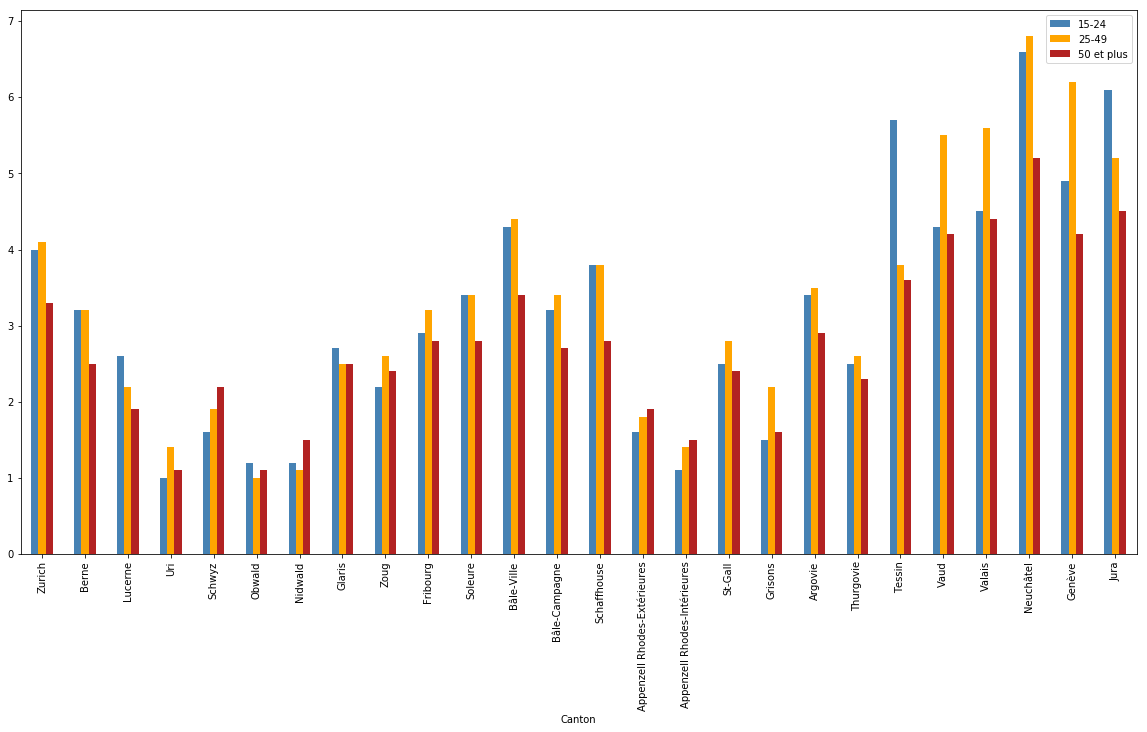

In [88]:
barplot(2016,swiss_young_db,swiss_med_db,swiss_old_db)